In [1]:

%load_ext autoreload
%reload_ext autoreload 


In [2]:
import tensorflow as tf
import numpy as np

In [3]:
import tensorflow_datasets as tfds

first we will try to get the data may be from some folder or like here
tensorflow datasets, If we have a folder, then we need to put them in tensorflow datasets for training.

- If we need some preprocessing before training for example augmentation or normalization we can simply build a funcion for one one example set and put them `map` function then tensorflow will optimize them for `gpu` and `parallel processing`

In [4]:
# If you hit a problem with checksums, you can execute the following line first
#!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [5]:
# see the possible keys we can access in the dataset dict.
# this contains the test and train splits.
print(dataset.keys())

dict_keys(['test', 'train'])


In [6]:
# see information about the dataset
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [7]:
from preprocess_data import load_image_train, load_image_test

# Creating dataset for training and testing

In [8]:
train = dataset['train'].map(
    load_image_train,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [9]:
train

<ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.uint8)>

In [10]:
test = dataset['test'].map(
    load_image_test,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [11]:
from configuration_file import BATCH_SIZE, BUFFER_SIZE
from configuration_file import class_names

In [12]:
# shuffle and group the train set into batches
train_dataset = train.cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

In [13]:
test_dataset = test.batch(BATCH_SIZE)

# Now try to visualize the data whether it is correctly done or not

In [14]:
from viz_utils import show_image_from_dataset

dict_keys(['test', 'train'])
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi

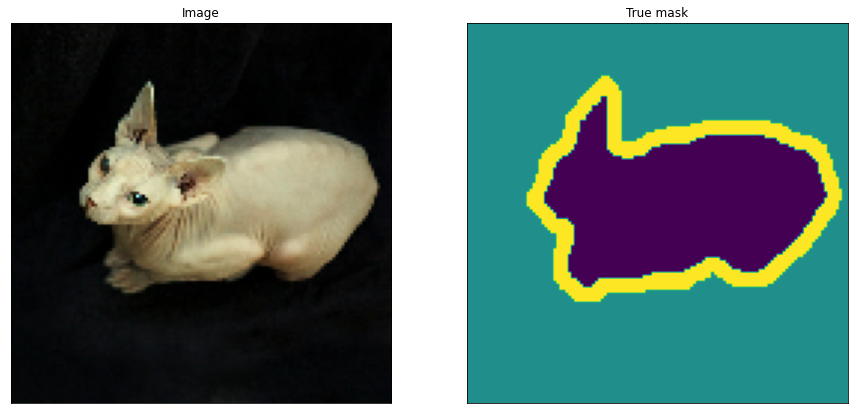

In [15]:
show_image_from_dataset(train)

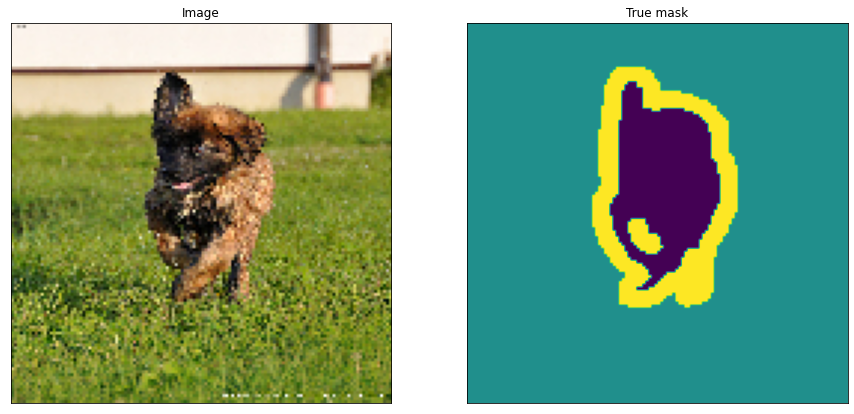

In [16]:
show_image_from_dataset(test)

# Now we will crealte Unet Model

In [17]:
from model_creation import unet

model = unet()

In [18]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       activation[0][0]                 
_______________________________________________________________________________________

## Compile and Train the model

Now, all that is left to do is to compile and train the model. The loss you will use is `sparse_categorical_crossentropy`. The reason is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class and `sparse_categorical_crossentropy` is the recommended loss for such a scenario. 

In [19]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
from configuration_file import EPOCHS, VAL_SUBPLITS


In [21]:
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE// VAL_SUBPLITS

In [22]:
# this will take around 20 minutes to run
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/10
 2/57 [>.............................] - ETA: 9s - loss: 2.3604 - accuracy: 0.3755WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1286s vs `on_train_batch_end` time: 0.2113s). Check your callbacks.


57/57 [==============================] - 20s 354ms/step - loss: 0.9922 - accuracy: 0.5645 - val_loss: 0.9111 - val_accuracy: 0.5736
Epoch 2/10
57/57 [==============================] - 20s 348ms/step - loss: 0.8483 - accuracy: 0.5970 - val_loss: 0.8112 - val_accuracy: 0.6151
Epoch 3/10
57/57 [==============================] - 20s 353ms/step - loss: 0.7664 - accuracy: 0.6517 - val_loss: 0.7462 - val_accuracy: 0.6742
Epoch 4/10
57/57 [==============================] - 20s 351ms/step - loss: 0.6847 - accuracy: 0.7156 - val_loss: 0.6340 - val_accuracy: 0.7406
Epoch 5/10
57/57 [==============================] - 20s 350ms/step - loss: 0.5939 - accuracy: 0.7607 - val_loss: 0.6146 - val_accuracy: 0.7469
Epoch 6/10
57/57 [==============================] - 20s 350ms/step - loss: 0.5423 - accuracy: 0.7868 - val_loss: 0.5185 - val_accuracy: 0.7970
Epoch 7/10
57/57 [==============================] - 20s 351ms/step - loss: 0.4891 - accuracy: 0.8112 - val_loss: 0.4701 - val_accuracy: 0.8193
Epoch 8/10

In [23]:
from viz_utils import plot_metrics

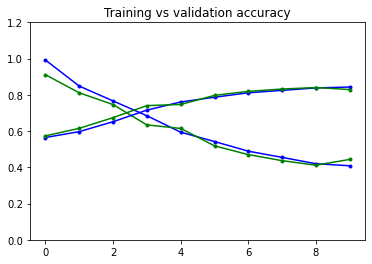

In [24]:
plot_metrics(model_history, 'loss', title='Training vs validation loss')
plot_metrics(model_history, 'accuracy', title='Training vs validation accuracy')

# Trained Model prediction

In [25]:
#model.save('whole_model.h5')

model= tf.keras.models.load_model('whole_model.h5')

In [26]:
# feed the test set to th emodel to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)

In [27]:
results.shape

(3648, 128, 128, 3)

In [28]:
results = np.argmax(results, axis=3)
results.shape

(3648, 128, 128)

In [29]:
results = results[..., tf.newaxis]
results.shape

(3648, 128, 128, 1)

# Get actual label mask from the test dataset

In [30]:
from viz_utils import get_test_image_and_annotation_array

In [31]:
y_true_images, y_true_segments = get_test_image_and_annotation_array(test_dataset)

In [32]:
y_true_images.shape, y_true_segments.shape

((3648, 128, 128, 3), (3648, 128, 128, 1))

# Comparing test data 

In [33]:
from test_accuracy_check import class_wise_metrics

In [34]:
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [35]:
# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou)) 

pet         0.725869820289827 
background  0.8382530912376635 
outline     0.3469755109023919 


In [36]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 

pet         0.841164045812133 
background  0.9120105335151643 
outline     0.5151920106851 


# Showing image of the prediction

In [37]:
from test_accuracy_check import make_prediction

In [38]:
from viz_utils import display_with_metrics

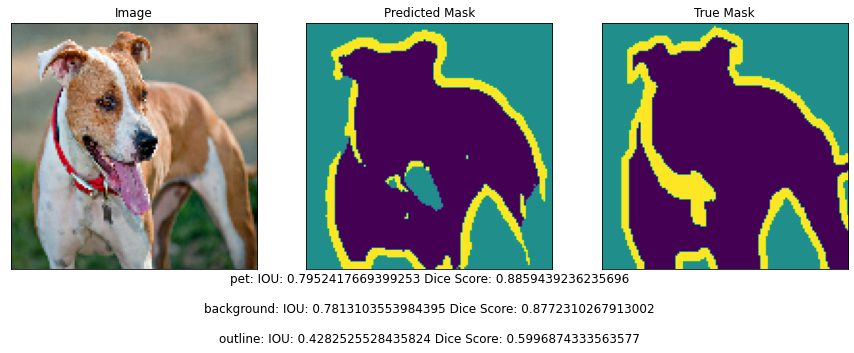

In [39]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 3646

# Get the prediction mask
y_pred_mask = make_prediction(model, y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  

# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)

In [ ]:
y_true_images[integer_slider].shape[0]